# Exploring Data

## Goals: 
 - To explore data utilizing spark, we have to adjust our technique to the limitations and context of the manner in which data is viewed and utilized in distributed learning.  We will use some of the techniques we have already explored and observe the pros and cons of examining the data in these specific ways.

## Ways to explore data from Spark:

 - We know that spark is a distributed data platform, which means that we generally cannot explore the full scope of data in the same manner as we would do with a smaller and locally contained data set.

### 1. Work with all of the data in Spark
 - Pros:
        - Produces the most accurate representation of the data
 - Cons:
        - Limited by spark operations
        - Cannot do visualizations 

### 2. Work with a sample of the data in local memory with pandas
 - Pros:
        - We can utilize all of the data exploration and data visualization tools we are accustomed to
 - Cons:
        - We are by nature only working with a subset of the data and could miss trends over the whole data set

### 3. Aggregate the data with Spark, then work with the aggregated data locally
 - Pros:
        - Meets 1 and 2's limitations half way by taking consideration from 1 and 2
        - We don't miss out on scope-oriented information, and we can work with the data in pandas
 - Cons:
        - We are limited to what we can do with spark aggregations
        - Aggregations will generally change the shape of data, and we will lose granularity of data.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

# df = wrangle_311(spark)
# print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)



In [2]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



### 1. Work with all of the data in Spark

How many opened and closed cases are there?

In [3]:
df.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



What's the average amount of time a case is open?

In [4]:
df.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108263294778737|
+-----------+------------------+



### Let's take a peak itno #3 since we've already made an aggregation -- we'll take that and look at it in pandas

What does the case distribution look like for each department?

In [5]:
df.groupBy("department").count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [7]:
(
# pull the group by on department
df.groupBy("department")
# aggregrate by count
    .count()
# then pass to pandas to create a dataframe
    .toPandas()
# utilize the department name as our index    
    .set_index("department"))['count']

department
Solid Waste                 279270
Animal Care Services        116915
Trans & Cap Improvements     96193
Parks & Recreation           19907
Customer Service              2849
Metro Health                  5163
City Council                    33
DSD/Code Enforcement        321374
Name: count, dtype: int64

Text(0.5, 0, 'Number of Cases')

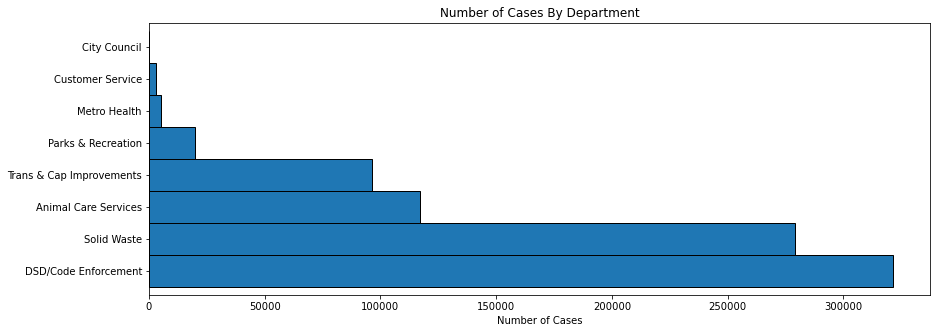

In [8]:
# First aggregate with spark
(
# group by    
    df.groupBy("department")
# aggregate by count    
    .count()
# then pass to pandas
    .toPandas()
# once its a dataframe, pass department as our index
    .set_index("department")["count"]
# sort our values for cleanliness of visualization
    .sort_values(ascending=False)
# pass our Series (department count values) to matplotlib
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

### What if we wanted to check out average case life per department?

Text(0.5, 1.0, 'Case Lifetime By Department')

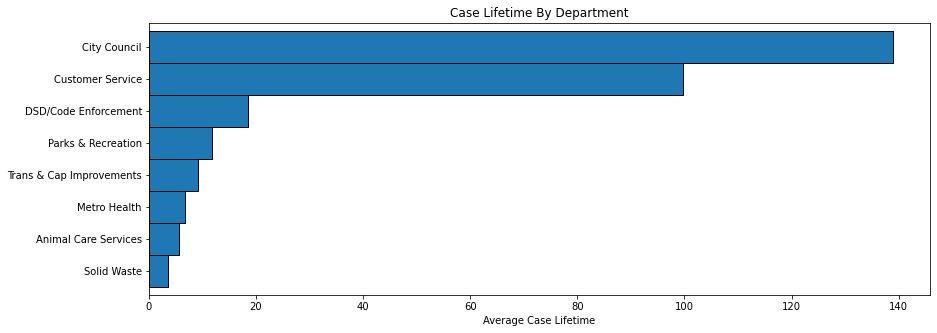

In [9]:
# first aggregate with spark
(
# group by
    df.groupBy("department")
# aggregate by average case lifetime here (alias will allow us to reference the
# column by an easier name)
    .agg(mean("case_lifetime").alias("avg_case_lifetime"))
# then pass the data to pandas for visualization
    .toPandas()
# set our index to department
    .set_index("department")
# reference the column we created by aggregation, sort values for visual storytelling
    .avg_case_lifetime.sort_values(ascending=True)
# pass Series to matplotlib
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Case Lifetime By Department")

Average case lifetime by department for both open and closed cases:

In [11]:
(
# group by
    df.groupBy("department")
# pivot with case status    
    .pivot("case_status")
# aggregate on the mean case lifetime (round to two decimal points)
    .agg(round(mean("case_lifetime"), 2))
# order by closed cases similarly to the way we would in SQL
    .orderBy("Closed")
# pulling our .show() (not putting data to pandas this time)
    .show(truncate=False)
)

+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.45 |
|Animal Care Services    |5.51  |21.36 |
|Metro Health            |6.82  |4.64  |
|Trans & Cap Improvements|8.0   |54.39 |
|Parks & Recreation      |10.66 |64.72 |
|DSD/Code Enforcement    |15.64 |91.56 |
|City Council            |29.25 |154.07|
|Customer Service        |48.94 |172.94|
+------------------------+------+------+



### 2. Exploration of a Sample

We can choose to take a sample of our big data using the `.sample` method, convert that data to a pandas dataframe, and then work with the sample.

In [12]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()

shape: (8522, 20)


,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


Here the `fraction` keyword argument tells spark what fraction of the data to use, and the `seed` keyword argument sets the random seed so that our random sampling is reproducible.

Now that we have the data in pandas, we can explore it with tools like searborn's pair plot:

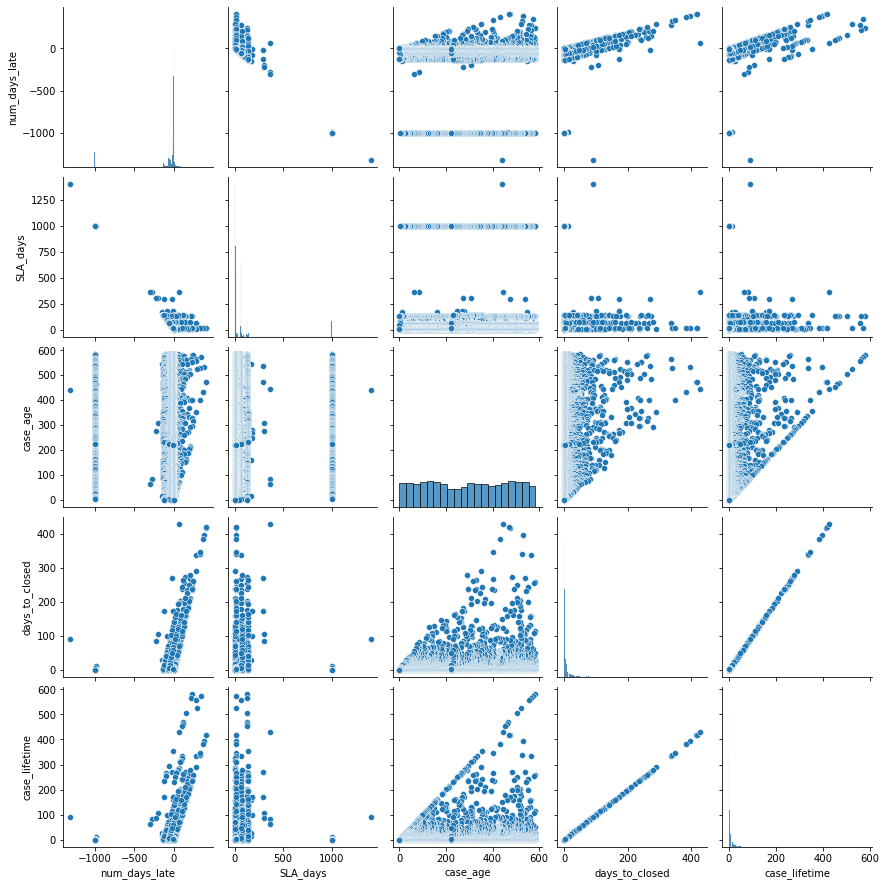

In [15]:
numeric_cols = [
    "num_days_late",
    "SLA_days",
    "case_age",
    "days_to_closed",
    "case_lifetime",
]

sns.pairplot(sample[numeric_cols])

The above example would not work with a spark dataframe, and even if it did, it would take a very long time to run.

Let's explore the distribution of the `case_lifetime` feature a little more:

<AxesSubplot:ylabel='Frequency'>

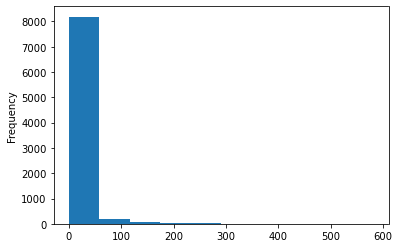

In [16]:
sample.case_lifetime.plot.hist()

It looks like the vast majority of the data points are close to 0, but there are a few outliers. One way we can look at this data in a more meaningful way is to bin the data into bins of a custom width.

For example, without setting custom bins, the results we get aren't terribly meaningful, much like the histogram above.

In [17]:
pd.cut(sample.case_lifetime, 4).value_counts().sort_index()

(-0.581, 145.25]    8414
(145.25, 290.5]       84
(290.5, 435.75]       15
(435.75, 581.0]        9
Name: case_lifetime, dtype: int64

However, we can define custom bins like so:

In [18]:
# In the call to `pd.cut`, we add right=False so that the behavior of pd.cut
# aligns with the behavior of np.histogram, which is what matplotlib uses when
# constructing a histogram.

# custom bins of varying widths
bins = [0, 1, 2, 5, 15, 1000]

print(
    pd.cut(sample.case_lifetime, bins, right=False).value_counts().sort_index()
)

[0, 1)        2539
[1, 2)        1649
[2, 5)        1453
[5, 15)       1449
[15, 1000)    1432
Name: case_lifetime, dtype: int64


Text(0.5, 1.0, 'Overall Case Lifetime')

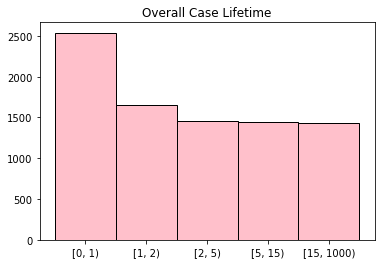

In [19]:
pd.cut(
    sample.case_lifetime, bins, right=False
).value_counts().sort_index().plot.bar(
    width=1, edgecolor="black", color="pink"
)
plt.xticks(rotation=0)
plt.title("Overall Case Lifetime")

Now we can see the distribution of case lifetimes a bit better.

Let's see how the distribution of lifetimes for just closed cases varies:

In [22]:
# sample[sample.case_closed == True]

In [23]:
closed_cases = sample.query("case_closed")
open_cases = sample.query("not case_closed")

Text(0.5, 0.98, 'Distribution of Case Lifetime')

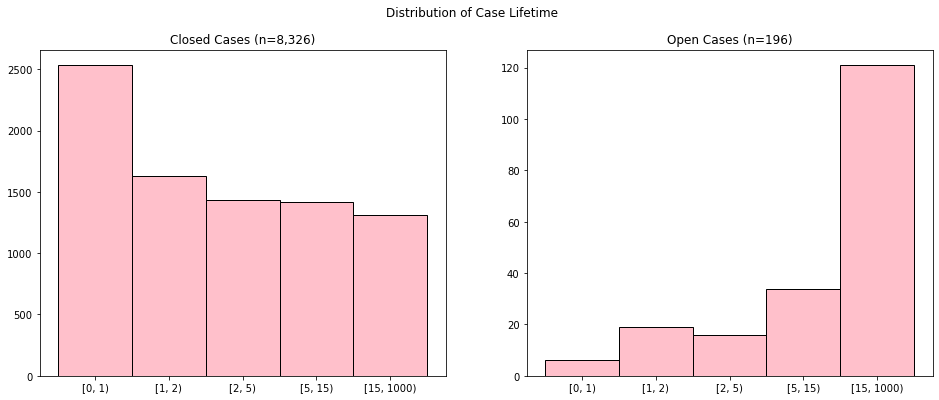

In [24]:
# set our figure size
plt.figure(figsize=(16, 6))

# establish first subplot
plt.subplot(121)
(
# use pd.cut to establish our custom bins
    pd.cut(closed_cases.case_lifetime, bins=bins, right=False)
# take our value counts
    .value_counts()
# sort our index
    .sort_index()
# pass the series to a bar plot
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Closed Cases (n={:,})".format(closed_cases.shape[0]))
plt.xticks(rotation=0)

plt.subplot(122)
(
    pd.cut(open_cases.case_lifetime, bins=bins, right=False)
    .value_counts()
    .sort_index()
    .plot.bar(width=1, edgecolor="black", color="pink", ax=plt.gca())
)
plt.title("Open Cases (n={:,})".format(open_cases.shape[0]))
plt.xticks(rotation=0)

plt.suptitle("Distribution of Case Lifetime")

## Exploring Aggregated Results

Our last strategy for exploratory analysis of big data is to use spark to aggregate our results and explore the aggregated result set.

Here we will count the number of cases closed and opened on each date, and then explore the resulting time series dataset.

In [25]:
# utilize .select on our df (spark dataframe)
cases_by_day = df.select(
    "department",
# format our dates
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)

+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



In [26]:
# assign a new dataframe from our spark dataframe called cases opened by day
cases_opened_by_day = (
# reference cases by day that we just created
    cases_by_day
# group by case opened date
    .groupby('case_opened_date')
# aggregate by count
    .count()
# drop any null values
    .na.drop()
# sort by the dates    
    .sort('case_opened_date')
# send it to pandas
    .toPandas()
# turn case opened date into a pandas datetime    
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
# set the datetime as our index
    .set_index('case_opened_date')
# reference the count Series in our dataframe
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [28]:
type(cases_opened_by_day)

pandas.core.series.Series

In [29]:
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [30]:
cases_closed_by_day

case_closed_date
2017-01-01      67
2017-01-02     385
2017-01-03     734
2017-01-04    1206
2017-01-05    1173
              ... 
2018-08-04     730
2018-08-05     197
2018-08-06    1713
2018-08-07    2096
2018-08-08     680
Name: cases_closed, Length: 585, dtype: int64

In [32]:
# Glue our Series together using our datetime index
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts.shape

(585, 2)

In [33]:
ts.head()

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173


In [35]:
ts.resample("M").mean().shape

(20, 2)

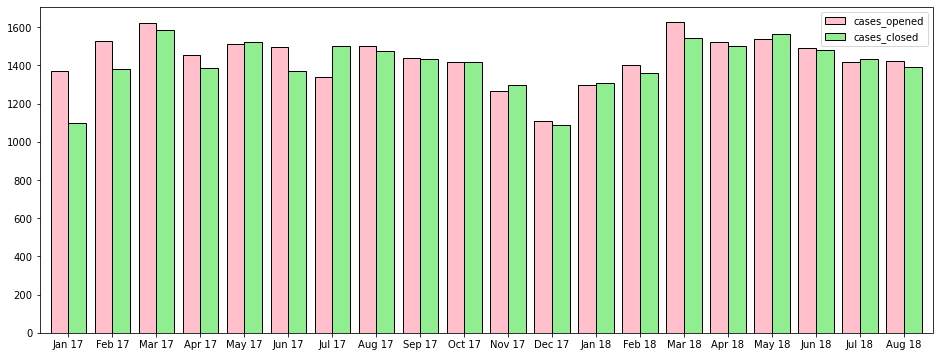

In [37]:
# Let's compress this and analyze by resampling to the month
ts.resample("M").mean().plot.bar(
# pass it to a bar plot    
    figsize=(16, 6), width=0.8, ec="black", color=["pink", "lightgreen"]
)

# pretty x-axis labels
ticks, labels = plt.xticks()
labels = pd.to_datetime([l.get_text() for l in labels]).strftime("%b %y")
plt.xticks(ticks, labels, rotation=0)
plt.show()

## Exercises

These exercises should go in a notebook or script named `explore`. 

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

- How many different cases are there, by department?
- Does the percentage of cases that are late vary by department?
- On average, how late are the late cases by department?
- What is the service type that is the most late? Just for Parks & Rec?
- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
- Does whether or not its a weekend matter for when a case is opened/closed?
- On average, how many cases are opened a day for the Customer Service department?
- Does the number of service requests for the solid waste department vary by day of the week?